In [19]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore
from matplotlib.colors import LogNorm
from os.path import join
import pickle
from matplotlib.colors import TwoSlopeNorm
from scipy import ndimage
from copy import deepcopy
import scipy
from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# edit these to your liking
bin_cm = 2.5

# load files
spikes_file = '/Users/harryclark/Downloads/One-shot entorhinal maps enable flexible navigation in novel environments - part 2/Head-Fixed Dark Running and Freely Moving Open Field Foraging/AO1_231222_postop_day10_dark01_g0_imec0_spikes.txt'
with open(spikes_file, 'rb') as file:
    spikes = pickle.load(file)

position_file = '/Users/harryclark/Downloads/One-shot entorhinal maps enable flexible navigation in novel environments - part 2/Head-Fixed Dark Running and Freely Moving Open Field Foraging/AO1_231222_postop_day10_OF01_g1_position.txt'
with open(position_file, 'r') as file:
    position = pd.read_csv(file)
    
arena_file = '/Users/harryclark/Downloads/One-shot entorhinal maps enable flexible navigation in novel environments - part 2/Head-Fixed Dark Running and Freely Moving Open Field Foraging/AO1_231222_postop_day10_OF01_g1_arena.txt'
with open(arena_file, 'r') as file:
    arena = eval(file.read())
border = arena['coordinates']['border']

dark_file = '/Users/harryclark/Downloads/One-shot entorhinal maps enable flexible navigation in novel environments - part 2/Head-Fixed Dark Running and Freely Moving Open Field Foraging/AO1_231222_postop_day10_dark01.mat'
dark_track_position = scipy.io.loadmat(dark_file)


In [26]:
dark_track_position

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Aug  2 10:20:12 2024',
 '__version__': '1.0',
 '__globals__': [],
 'all_maps': array([[[ 4.52409474,  8.74534363,  7.42518859, ...,  0.        ,
           0.        ,  0.90814474],
         [ 4.88402684,  1.77088225,  3.05251678, ...,  1.08977369,
           4.88402684,  8.05239894],
         [ 0.        ,  0.90814474,  4.07002237, ...,  6.10503355,
           1.36221711,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  8.14004473,
           1.81628948,  0.        ],
         [ 1.36221711,  6.10503355, 10.06549867, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],
 
        [[ 0.90814474,  4.97816711, 10.78035481, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
 

In [25]:
np.shape(dark_track_position['all_maps'])

(393, 468, 100)

In [3]:
def min_max_normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def find_set(a, b):
    return set(a) & set(b)

In [4]:
def calc_ego_autocorr(spike_times,t,x,y,hd):

    x = np.interp(spike_times, t, x)
    y = np.interp(spike_times, t, y)
    hd = np.interp(spike_times, t, hd)

    x_spike_stack = np.vstack([x]*len(x))
    y_spike_stack = np.vstack([y]*len(y))

    x_spike_stack = x_spike_stack - x[:,None]
    y_spike_stack = y_spike_stack - y[:,None]

    tmp1 = (np.cos(hd)[:,None]*x_spike_stack).astype(np.int8)
    tmp2 = (np.sin(hd)[:,None]*y_spike_stack).astype(np.int8)
    rotated_pos_from_spikes_x = tmp1 - tmp2

    tmp1 = (np.sin(hd)[:,None]*x_spike_stack).astype(np.int8)
    tmp2 = (np.cos(hd)[:,None]*y_spike_stack).astype(np.int8)
    rotated_pos_from_spikes_y = tmp1 + tmp2

    rotated_pos_from_spikes_x = rotated_pos_from_spikes_x.astype(np.int16).flatten()
    rotated_pos_from_spikes_y = rotated_pos_from_spikes_y.astype(np.int16).flatten()

    autocorrelogram_2d, xedges, yedges = np.histogram2d(rotated_pos_from_spikes_x, 
                                                        rotated_pos_from_spikes_y,
                                                        bins=[100,100], 
                                                        range=[[-100, 100], [-100, 100]], 
                                                        density=False)

    euclidean_distances = np.sqrt((np.square(rotated_pos_from_spikes_x)
                                   +np.square(rotated_pos_from_spikes_y)))

    autocorrelogram_1d, bin_edges = np.histogram(euclidean_distances, bins=50, range=[0, 100], density=False)

    autocorrelogram_2d[50,50] = autocorrelogram_2d[50,49] # negate the middle point

    return autocorrelogram_2d, autocorrelogram_1d, bin_edges

In [5]:
def calc_fr_map(st, position, border, bin_cm=2, smooth=False):
    '''Firing rate at each xy position for 1 cell'''
    times = position['Timestamp']
    x = position['X']
    y = position['Y']
    occupancy, xbins, ybins, _ = calc_occupancy(position, border, bin_cm)
    binned_spikes = bin_spikes(st, times)
    spike_map = get_spike_map(binned_spikes, x, y, xbins, ybins)
    fr_map = get_fr_map(spike_map, occupancy)
    if smooth:
        fr_map = smooth_2d_map(fr_map)
        
    max_bin = np.where(spike_map==np.max(spike_map))
    x = max_bin[0][0]
    y = max_bin[1][0]
    max_fr = spike_map[x,y]/occupancy[x,y]
    return fr_map, xbins, ybins, max_fr

def bin_spikes(st, times):
    '''Converts spiketimes to spikecounts binned by times (e.g. camera frames) for 1 cell'''
    # add a bin to the end so # bins matches # position datapoints
    times = np.asarray(times)
    timestep = times[-1]/len(times)
    bins = np.append(times, times[-1]+timestep)
    binned_spikes = np.histogram(st, bins)
    return binned_spikes[0]

def get_spike_map(bin_spikes, x, y, x_bin_edges, y_bin_edges):
    """
    :param np.array bin_spikes: spike counts by time bin
    :param np.array x: x bin position of animal
    :param np.array y: y bin position of animal
    :param x_bin_edges: np.array of edges
    :param y_bin_edges: np.array of edges
    :return: np.ndarray spike_map: number of spikes at each xy position
    """
    x_spk, y_spk = get_bin_spikes_xy(bin_spikes, x, y)
    spike_map, _, _ = np.histogram2d(y_spk, x_spk, bins=[y_bin_edges, x_bin_edges])
    return spike_map

def get_bin_spikes_xy(bin_spikes, x, y):
    """
    :param np.array bin_spikes: spike counts by time bin
    :param np.array x: x bin position of animal
    :param np.array y: y bin position of animal
    :return: np.arrays x_spikes, y_spikes: positions for each spike (length=n_spikes)
    """
    max_n_spikes = np.max(bin_spikes)
    x_spikes = []
    y_spikes = []
    for n_spk in np.arange(1, max_n_spikes + 1):
        x_spikes += x[bin_spikes == n_spk].tolist() * int(n_spk)
        y_spikes += y[bin_spikes == n_spk].tolist() * int(n_spk)
    assert len(x_spikes) == np.sum(bin_spikes), 'Spikes To Position Mismatch'
    return x_spikes, y_spikes

def get_fr_map(spike_map, pos_map_secs):
    """
    :param np.ndarray spike_map: number of spikes at each xy position
            -> as returned by get_spike_map()
    :param np.ndarray pos_map_secs: occupation map in seconds
            -> obtained from get_position_map() and normalized by the time_step
    :return: np.ndarray fr_map: same shape as the inputs. firing rate at each xy position
            -> will probably need smoothing after
    """
    pos_map_secs2 = np.array(pos_map_secs, dtype=np.float32)
    pos_map_secs2[pos_map_secs == 0] = np.nan  # convert zero occupation bins to nan
    fr_map = spike_map / pos_map_secs2
    fr_map[np.isnan(fr_map)] = 0  # convert zero occupation bins to 0
    return fr_map

def smooth_2d_map(bin_map, n_bins=2, sigma=1.5, apply_median_filt=True, **kwargs):
    """
    :param bin_map: map to be smooth.
        array in which each cell corresponds to the value at that xy position
    :param n_bins: number of smoothing bins
    :param sigma: std for the gaussian smoothing
    :return: sm_map: smoothed map. note that this is a truncated sigma map, meaning that high or
            low values wont affect far away bins
    """
    if apply_median_filt:
        sm_map = ndimage.median_filter(bin_map, n_bins, mode='constant')
    else:
        sm_map = bin_map

    return ndimage.gaussian_filter(sm_map, sigma, mode='constant')

def plot_position(position, border, spikes=None, by_segment=False):
    '''Plot position trace over entire session within borders
    Optionally overlay spikes from a single cell'''

    fig, ax = plt.subplots()
    us_per_frame = 51
    
    # plot borders
    points = deepcopy(border)
    points.append(points[0])
    x, y = zip(*points)
    ax.plot(x, y)

    # plot trajectory
    if by_segment:
        ax.scatter(position['X'], position['Y'], s=10,
            c=position['Segment'], cmap=plt.cm.RdYlBu,
            rasterized=True)
    else:
        ax.plot(position['X'], position['Y'], color='k',
            rasterized=True, zorder=1)

    if spikes is not None:
        hist_bins = np.asarray(position['Timestamp'])
        hist_bins = np.append(hist_bins, hist_bins[-1]+us_per_frame)
        spike_hist, _ = np.histogram(spikes, bins=hist_bins)
        x = position['X'][spike_hist > 0]
        y = position['Y'][spike_hist > 0]
        ax.scatter(x, y, color='r', rasterized=True, zorder=2)

    plt.show()
    return fig

def calc_occupancy(position, border, bin_cm=2, weights=None):
    '''Calculate occupancy matrix of bins of size bin_cm visited by mouse'''
    x = position['X']
    y = position['Y']
    wall_max = np.max(border, axis=0)
    xbins = np.linspace(bin_cm, wall_max[0], int(wall_max[0]/bin_cm)+1)
    ybins = np.linspace(bin_cm, wall_max[1], int(wall_max[1]/bin_cm)+1)
    # invert x & y so it plots corectly
    occupancy, _, _ = np.histogram2d(y, x, [ybins, xbins], weights=weights)
    # convert to seconds
    us_per_frame = 51
    occupancy *= us_per_frame/10**3
    # note that coverage is only meaningful for open field (box)
    coverage = np.sum(occupancy > 0)/(len(xbins)*len(ybins))
    return occupancy, xbins, ybins, coverage

In [27]:
spikes

{'name': '//oak-smb-giocomo.stanford.edu/groups/giocomo/export/data/Projects/JohnKei_NPH3\\AO1\\Spikes\\AO1_231222_postop_day10_dark01_g0_imec0_spikes.txt',
 'rec_file_path': '//oak-smb-giocomo.stanford.edu/groups/giocomo/export/data/Projects/JohnKei_NPH3\\AO1\\SuperCat\\AO1_231222_postop_day10_dark01\\supercat_AO1_231222_postop_day10_dark01_g0\\AO1_231222_postop_day10_dark01_g0_imec0',
 'ks_file_path': '//oak-smb-giocomo.stanford.edu/groups/giocomo/export/data/Projects/JohnKei_NPH3\\AO1\\SuperCat\\AO1_231222_postop_day10_dark01\\supercat_AO1_231222_postop_day10_dark01_g0\\AO1_231222_postop_day10_dark01_g0_imec0\\imec0_ks_john_physorted',
 'is_phy_curated': True,
 'rate': 30000,
 'spikes': [array([1.55356325e+00, 3.04779330e+00, 4.27402394e+00, ...,
         5.78646395e+03, 5.78724402e+03, 5.78811781e+03]),
  array([2.88999365e-02, 9.55997899e-02, 2.11799535e-01, ...,
         5.78734838e+03, 5.78736068e+03, 5.78764272e+03]),
  array([9.28197960e-01, 1.05416435e+00, 1.30526380e+00, ...

In [28]:
spikes['spikes']

[array([1.55356325e+00, 3.04779330e+00, 4.27402394e+00, ...,
        5.78646395e+03, 5.78724402e+03, 5.78811781e+03]),
 array([2.88999365e-02, 9.55997899e-02, 2.11799535e-01, ...,
        5.78734838e+03, 5.78736068e+03, 5.78764272e+03]),
 array([9.28197960e-01, 1.05416435e+00, 1.30526380e+00, ...,
        5.68465778e+03, 5.75298773e+03, 5.76850789e+03]),
 array([4.37165706e-01, 1.32963041e+00, 1.46223012e+00, ...,
        5.78622442e+03, 5.78787288e+03, 5.78824591e+03]),
 array([1.55899657e-01, 1.64899638e-01, 2.64899418e-01, ...,
        5.78306609e+03, 5.78410392e+03, 5.78800061e+03]),
 array([2.02999554e-02, 1.38666362e-01, 1.71666289e-01, ...,
        5.78806181e+03, 5.78825385e+03, 5.78833265e+03]),
 array([1.70999624e-02, 1.14666415e-01, 2.25499504e-01, ...,
        5.78362059e+03, 5.78806528e+03, 5.78820691e+03]),
 array([3.98332458e-02, 1.76199613e-01, 4.64998978e-01, ...,
        5.78745528e+03, 5.78747718e+03, 5.78797881e+03]),
 array([4.36565707e-01, 1.84789594e+00, 4.551123

0/220, neuron 0, has 1531 spikes
1/220, neuron 1, has 14343 spikes
2/220, neuron 2, has 50 spikes
3/220, neuron 3, has 12564 spikes
4/220, neuron 4, has 10920 spikes
5/220, neuron 5, has 9809 spikes
6/220, neuron 6, has 19560 spikes
7/220, neuron 7, has 37238 spikes
8/220, neuron 8, has 80 spikes
9/220, neuron 9, has 10969 spikes
10/220, neuron 10, has 5880 spikes
11/220, neuron 11, has 479 spikes
12/220, neuron 12, has 25140 spikes
13/220, neuron 13, has 11287 spikes
14/220, neuron 14, has 15722 spikes
15/220, neuron 15, has 78326 spikes
16/220, neuron 16, has 19942 spikes
17/220, neuron 17, has 15574 spikes
18/220, neuron 18, has 54992 spikes
19/220, neuron 19, has 7957 spikes
20/220, neuron 20, has 21587 spikes
21/220, neuron 21, has 3889 spikes
22/220, neuron 22, has 10393 spikes
23/220, neuron 23, has 11496 spikes
24/220, neuron 24, has 10723 spikes
25/220, neuron 25, has 830 spikes
26/220, neuron 26, has 8892 spikes
27/220, neuron 27, has 25003 spikes
28/220, neuron 28, has 80369

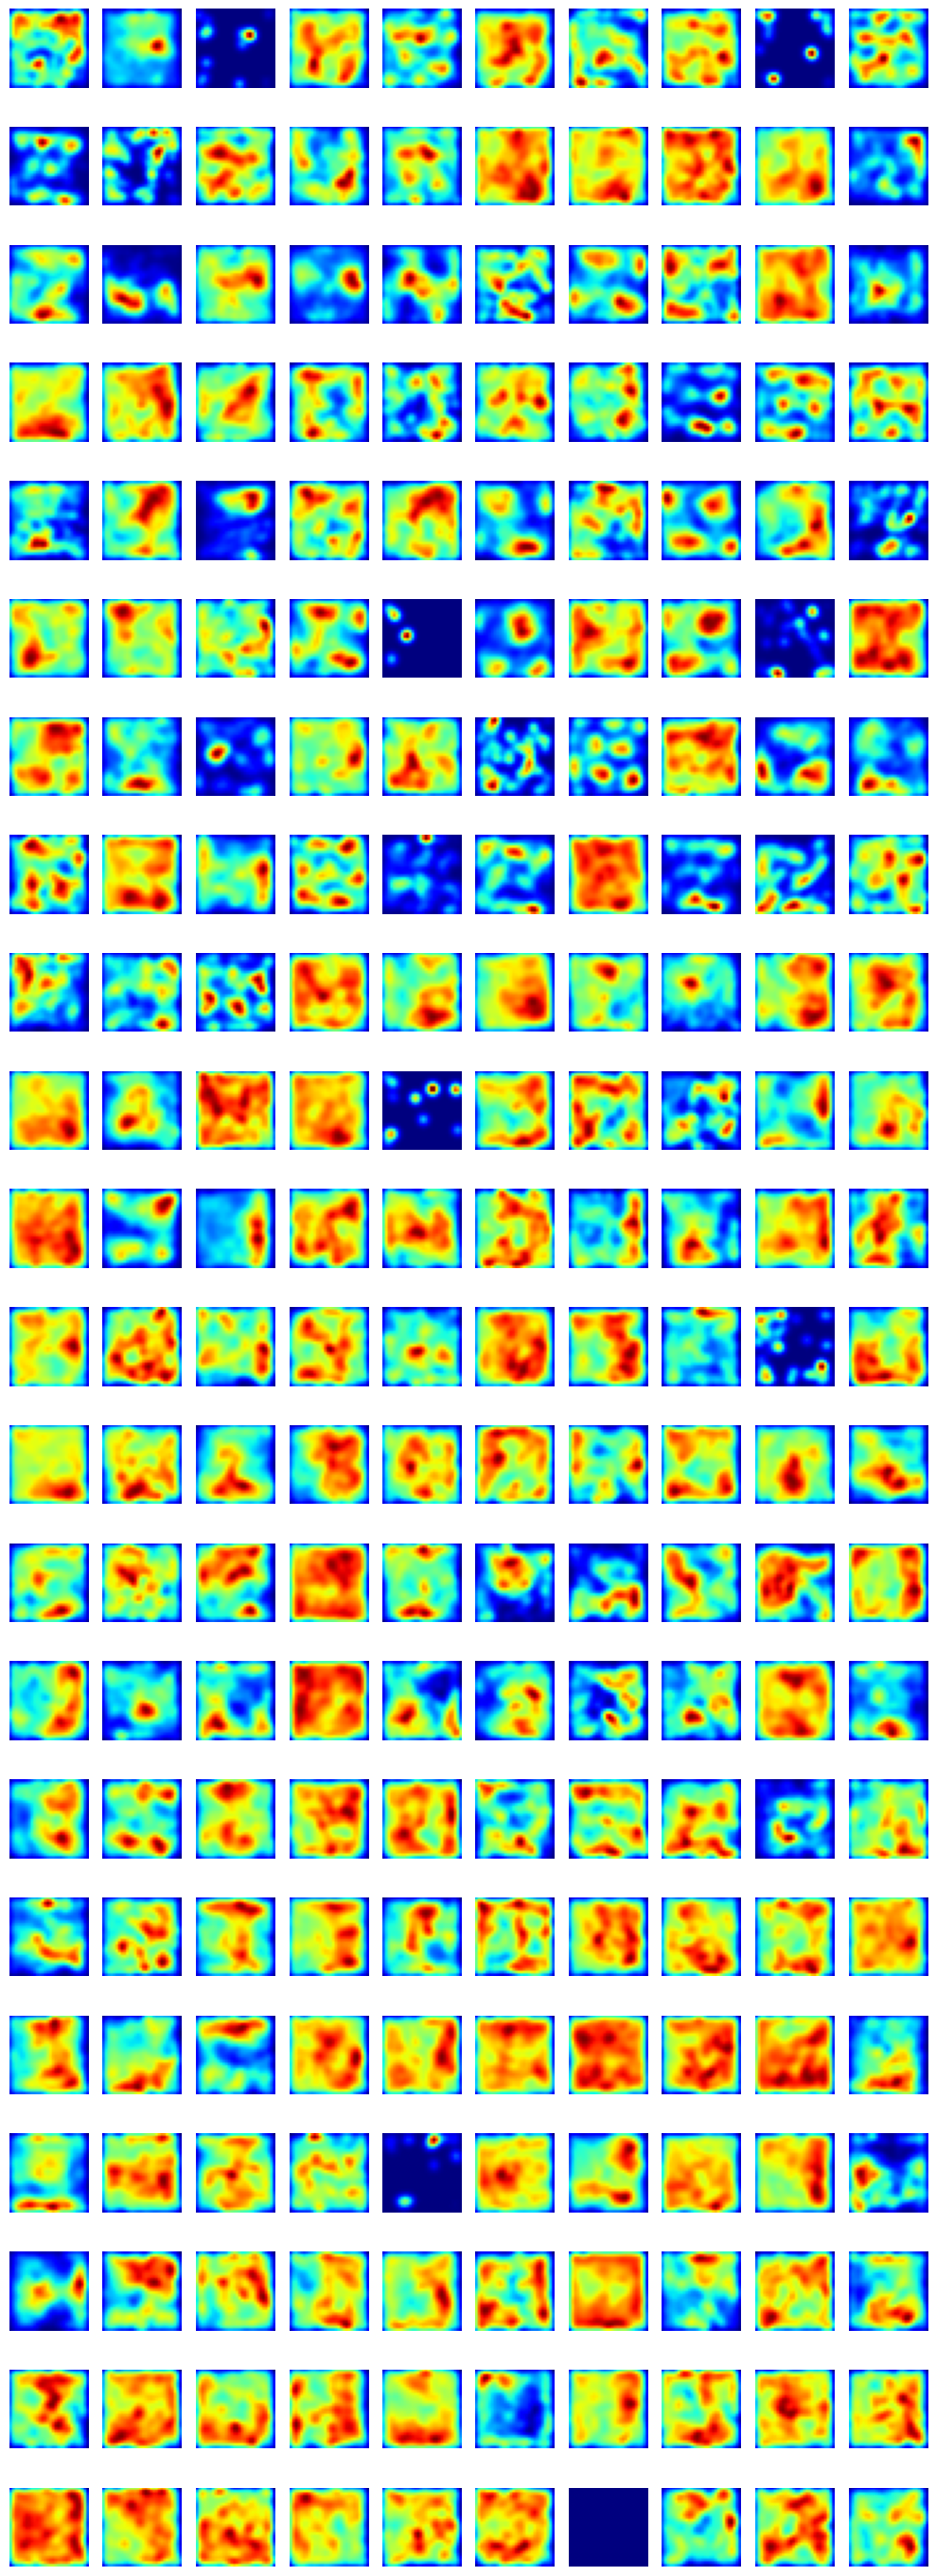

In [29]:
tcs = {}
n_cells = len(spikes['spikes'])
cids = spikes['cid']
c_spikes = spikes['spikes']
for u, (u_spikes, cid) in enumerate(zip(c_spikes, cids)):
    spike_times = spikes['spikes'][u]
    times = np.array(position['Timestamp'])
    x = np.array(position['X'])
    y = np.array(position['Y'])
    hd = np.array(position['HD'])

    # remove spikes outside of time range
    spike_times = spike_times[spike_times>times[0]]
    spike_times = spike_times[spike_times<times[-1]]

    n_spikes = len(spike_times)
    print(f'{u}/{n_cells}, neuron {u}, has {n_spikes} spikes')

    fr_map, xbins, ybins, max_fr = calc_fr_map(spikes['spikes'][u], 
                                               position, 
                                               border, bin_cm, smooth=True)

    tcs[cid] = fr_map
    
# Plot
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            fr_map = tcs[cids[counter]]
            ax[j, i].imshow(fr_map, cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()

length of session = 51.128951300000004 minutes


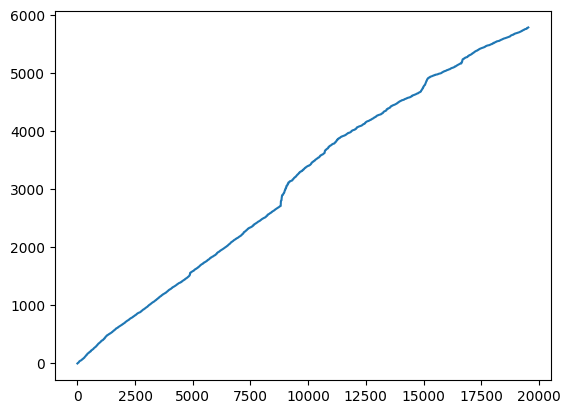

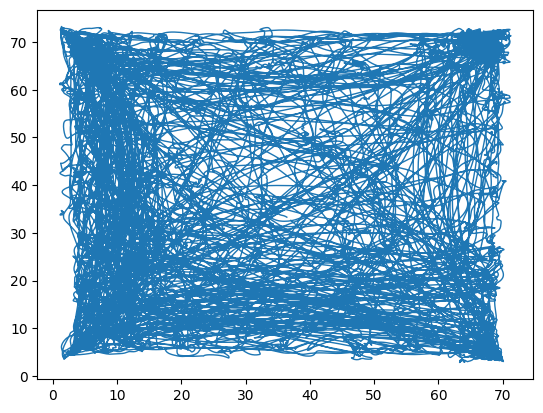

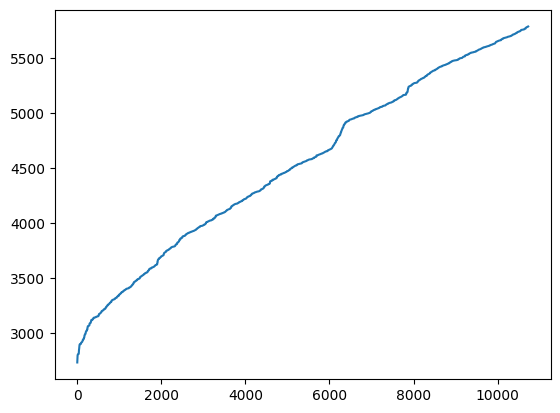

38/220, neuron 38, has 10729 spikes


In [10]:
u = 38
spike_times = spikes['spikes'][u]
times = np.array(position['Timestamp'])
x = np.array(position['X'])
y = np.array(position['Y'])
hd = np.array(position['HD'])

print(f'length of session = {(times[-1]-times[0])/60} minutes')
plt.plot(spike_times)
plt.show()

plt.plot(x,y, linewidth=1)
plt.show()

# remove spikes outside of time range
spike_times = spike_times[spike_times>times[0]]

plt.plot(spike_times)
plt.show()

n_spikes = len(spike_times)
print(f'{u}/{n_cells}, neuron {u}, has {n_spikes} spikes')

first spike at 0.06666652017412698
last spike at 5788.409847255829
first position time point at 2719.2143260000003
last position time point at 5786.951404
duration of position data = 51.128951300000004 minutes


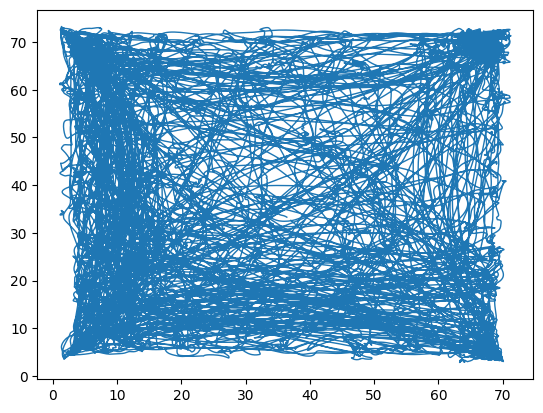

38/220, neuron 38, has 10725 spikes
reduced the spike count down for neuron 38, to 7500 spikes


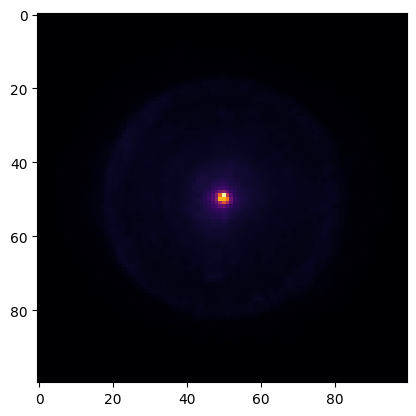

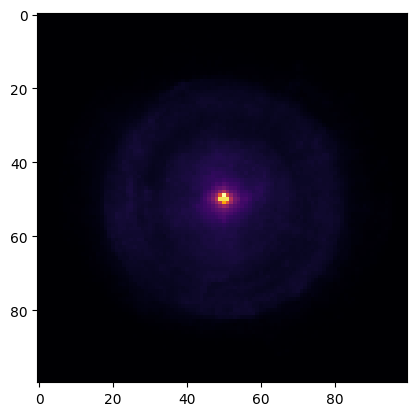

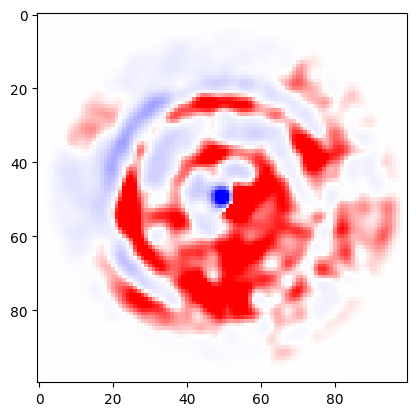

In [11]:
norm_autocorr_2ds = []
norm_autocorr_1ds = []
u = 38
spike_times = spikes['spikes'][u]
times = np.array(position['Timestamp'])

print(f'first spike at {spike_times[0]}')
print(f'last spike at {spike_times[-1]}')
print(f'first position time point at {times[0]}')
print(f'last position time point at {times[-1]}')
print(f'duration of position data = {(times[-1]-times[0])/60} minutes')

spike_times = spike_times-times[0]
times = times-times[0]
x = np.array(position['X'])
y = np.array(position['Y'])
hd = np.array(position['HD'])

plt.plot(x,y, linewidth=1)
plt.show()

# remove spikes outside of time range
spike_times = spike_times[spike_times>times[0]]
spike_times = spike_times[spike_times<times[-1]]

n_spikes = len(spike_times)
print(f'{u}/{n_cells}, neuron {u}, has {n_spikes} spikes')

if len(spike_times)>7500:
    spike_times=spike_times[:7500]
    print(f'reduced the spike count down for neuron {u}, to {len(spike_times)} spikes')

# completely random additions for each spike here
random_firing_addititions = np.random.randint(low=20, 
                                              high=np.nanmax(spike_times)-20, 
                                              size=len(spike_times))
shf_spike_times = spike_times + random_firing_addititions
shf_spike_times[shf_spike_times >= np.nanmax(spike_times)] = shf_spike_times[shf_spike_times >= np.nanmax(spike_times)] - np.nanmax(spike_times) # wrap around
shf_spike_times = np.sort(shf_spike_times)

autocorr_2d, autocorr_1d, bin_edges = calc_ego_autocorr(spike_times, t=times, x=x, y=y, hd=hd)
shf_autocorr_2d, shf_autocorr_1d, bin_edges = calc_ego_autocorr(shf_spike_times, t=times, x=x, y=y, hd=hd)

diff_autocorr_2d = autocorr_2d-shf_autocorr_2d
#autocorr_2d = min_max_normalize(autocorr_2d)
#shf_autocorr_2d = min_max_normalize(shf_autocorr_2d)
#diff_autocorr_2d = min_max_normalize(diff_autocorr_2d)

diff_autocorr_1d = autocorr_1d-shf_autocorr_1d

diff_autocorr_2d = gaussian_filter(diff_autocorr_2d, sigma=2.5/2)
diff_autocorr_1d = gaussian_filter(diff_autocorr_1d, sigma=2.5/2)

norm = TwoSlopeNorm(vmin=np.nanmin(diff_autocorr_2d)*0.5, 
                    vcenter=0, 
                    vmax=np.nanmax(diff_autocorr_2d)*0.3)    


plt.imshow(shf_autocorr_2d, cmap='inferno')
plt.show()

plt.imshow(autocorr_2d, cmap='inferno')
plt.show()

plt.imshow(diff_autocorr_2d, cmap='bwr', norm=norm)
plt.show()


In [12]:
n_cells = len(spikes['spikes'])
cids = spikes['cid']
c_spikes = spikes['spikes']

norm_autocorr_2ds = {}
norm_autocorr_1ds = {}
for u, (u_spikes, cid) in enumerate(zip(c_spikes, cids)):
    spike_times = spikes['spikes'][u]
    times = np.array(position['Timestamp'])
    x = np.array(position['X'])
    y = np.array(position['Y'])
    hd = np.array(position['HD'])

    spike_times = spike_times-times[0]
    times = times-times[0]

    # remove spikes outside of time range
    spike_times = spike_times[spike_times>times[0]]
    spike_times = spike_times[spike_times<times[-1]]

    n_spikes = len(spike_times)
    print(f'{u}/{n_cells}, neuron {u}, has {n_spikes} spikes')

    if len(spike_times)>7500:
        spike_times=spike_times[:7500]
        print(f'reduced the spike count down for neuron {u}, to {len(spike_times)} spikes')

    # completely random additions for each spike here
    random_firing_addititions = np.random.randint(low=20, 
                                                  high=np.nanmax(spike_times)-20, 
                                                  size=len(spike_times))
    shf_spike_times = spike_times + random_firing_addititions
    shf_spike_times[shf_spike_times >= np.nanmax(spike_times)] = shf_spike_times[shf_spike_times >= np.nanmax(spike_times)] - np.nanmax(spike_times) # wrap around
    shf_spike_times = np.sort(shf_spike_times)

    autocorr_2d, autocorr_1d, bin_edges = calc_ego_autocorr(spike_times, t=times, x=x, y=y, hd=hd)
    shf_autocorr_2d, shf_autocorr_1d, bin_edges = calc_ego_autocorr(shf_spike_times, t=times, x=x, y=y, hd=hd)

    diff_autocorr_2d = autocorr_2d-shf_autocorr_2d
    #autocorr_2d = min_max_normalize(autocorr_2d)
    #shf_autocorr_2d = min_max_normalize(shf_autocorr_2d)
    #diff_autocorr_2d = min_max_normalize(diff_autocorr_2d)

    diff_autocorr_1d = autocorr_1d-shf_autocorr_1d

    diff_autocorr_2d = gaussian_filter(diff_autocorr_2d, sigma=2.5/2)
    diff_autocorr_1d = gaussian_filter(diff_autocorr_1d, sigma=2.5/2)

    norm = TwoSlopeNorm(vmin=np.nanmin(diff_autocorr_2d)*0.5, 
                        vcenter=0, 
                        vmax=np.nanmax(diff_autocorr_2d)*0.3)    

    norm_autocorr_2ds[cid] = diff_autocorr_2d
    norm_autocorr_1ds[cid] = diff_autocorr_1d

0/220, neuron 0, has 1531 spikes
1/220, neuron 1, has 14343 spikes
reduced the spike count down for neuron 1, to 7500 spikes
2/220, neuron 2, has 50 spikes
3/220, neuron 3, has 12564 spikes
reduced the spike count down for neuron 3, to 7500 spikes
4/220, neuron 4, has 10920 spikes
reduced the spike count down for neuron 4, to 7500 spikes
5/220, neuron 5, has 9809 spikes
reduced the spike count down for neuron 5, to 7500 spikes
6/220, neuron 6, has 19560 spikes
reduced the spike count down for neuron 6, to 7500 spikes
7/220, neuron 7, has 37238 spikes
reduced the spike count down for neuron 7, to 7500 spikes
8/220, neuron 8, has 80 spikes
9/220, neuron 9, has 10969 spikes
reduced the spike count down for neuron 9, to 7500 spikes
10/220, neuron 10, has 5880 spikes
11/220, neuron 11, has 479 spikes
12/220, neuron 12, has 25140 spikes
reduced the spike count down for neuron 12, to 7500 spikes
13/220, neuron 13, has 11287 spikes
reduced the spike count down for neuron 13, to 7500 spikes
14/

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def sort_by_cosine_similarity(arrays):
    array_matrix = np.array(arrays)
    similarity_matrix = cosine_similarity(array_matrix)
    mean_similarity = np.mean(similarity_matrix, axis=1)
    sorted_indices = np.argsort(mean_similarity)[::-1]
    return sorted_indices

def apply_sorting_order(arrays, sorted_indices):
    array_matrix = np.array(arrays)
    sorted_arrays = array_matrix[sorted_indices]
    return sorted_arrays.tolist()


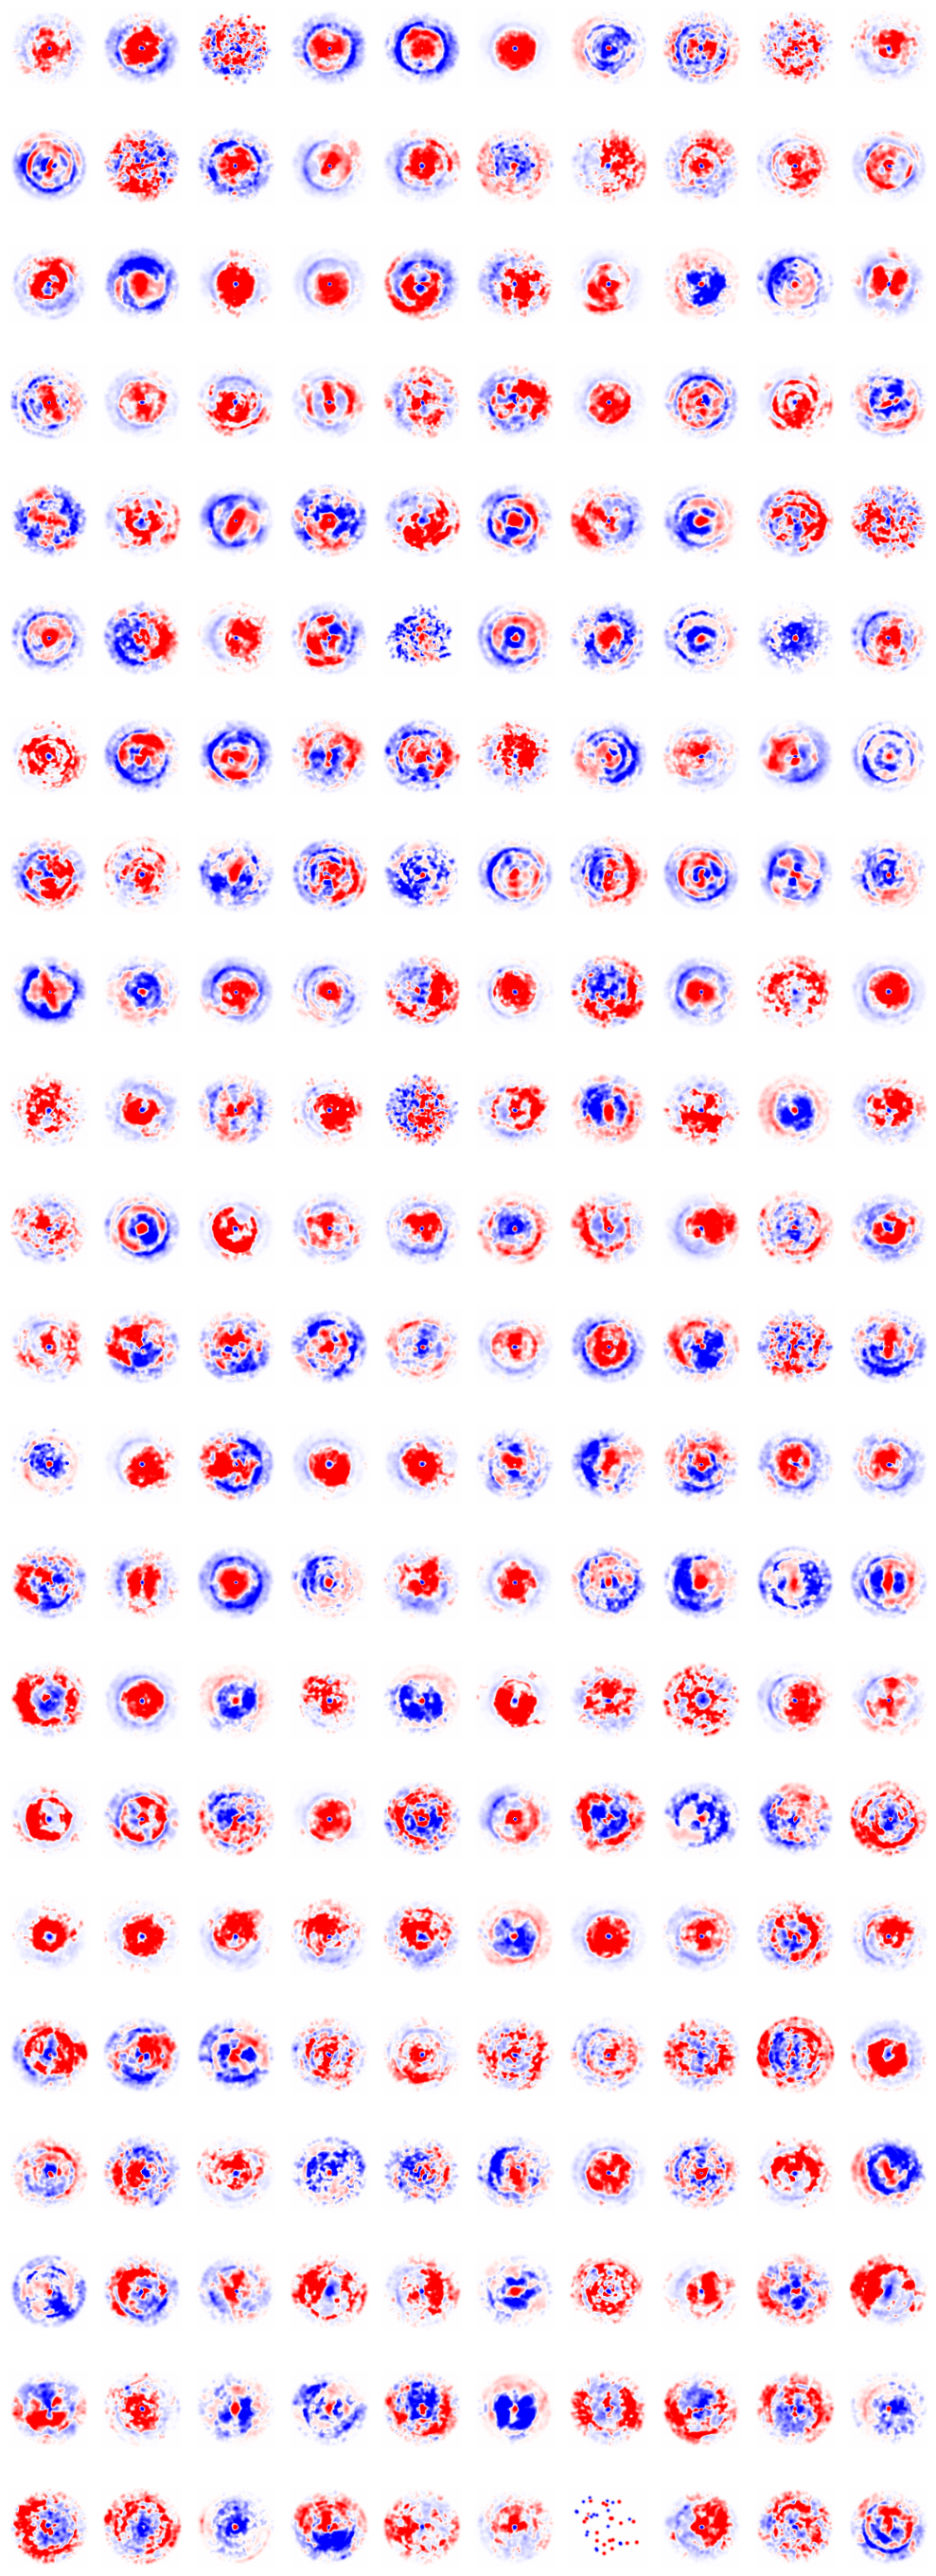

In [14]:
# Plot
ncols = 10
nrows = int(np.ceil(len(norm_autocorr_2ds)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(norm_autocorr_2ds)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(norm_autocorr_2ds):
            hm = norm_autocorr_2ds[cids[counter]]
            norm = TwoSlopeNorm(vmin=np.nanmin(hm)*0.5, 
                                vcenter=0, 
                                vmax=np.nanmax(hm)*0.3)
            ax[j, i].imshow(hm, cmap='bwr', norm=norm)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()

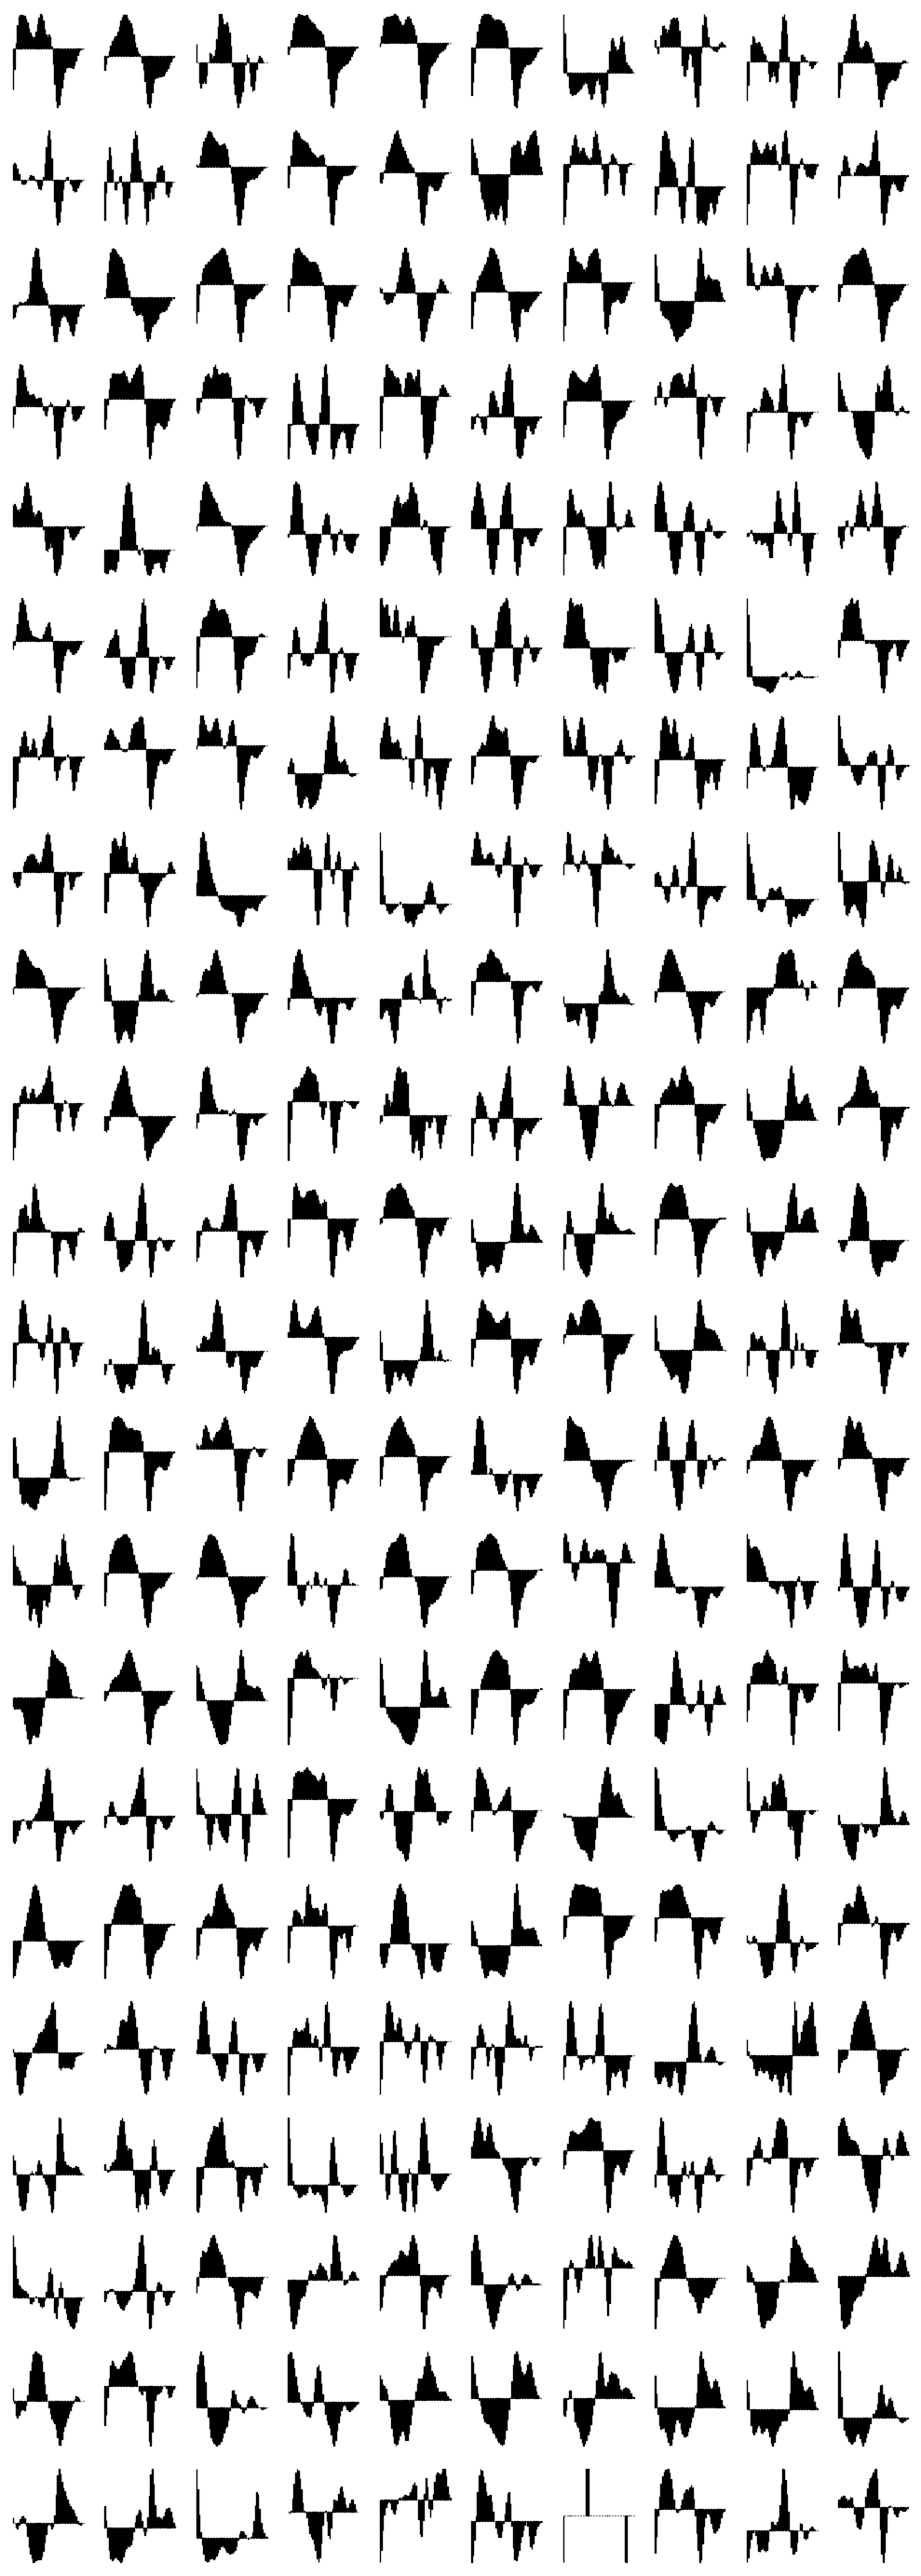

In [15]:
# Plot
bin_centres = 0.5*(bin_edges[1:]+bin_edges[:-1])

ncols = 10
nrows = int(np.ceil(len(norm_autocorr_1ds)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(norm_autocorr_1ds)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(norm_autocorr_1ds):
            ax[j, i].bar(bin_centres, norm_autocorr_1ds[cids[counter]],
                          color="black", edgecolor="black", align="edge")
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()

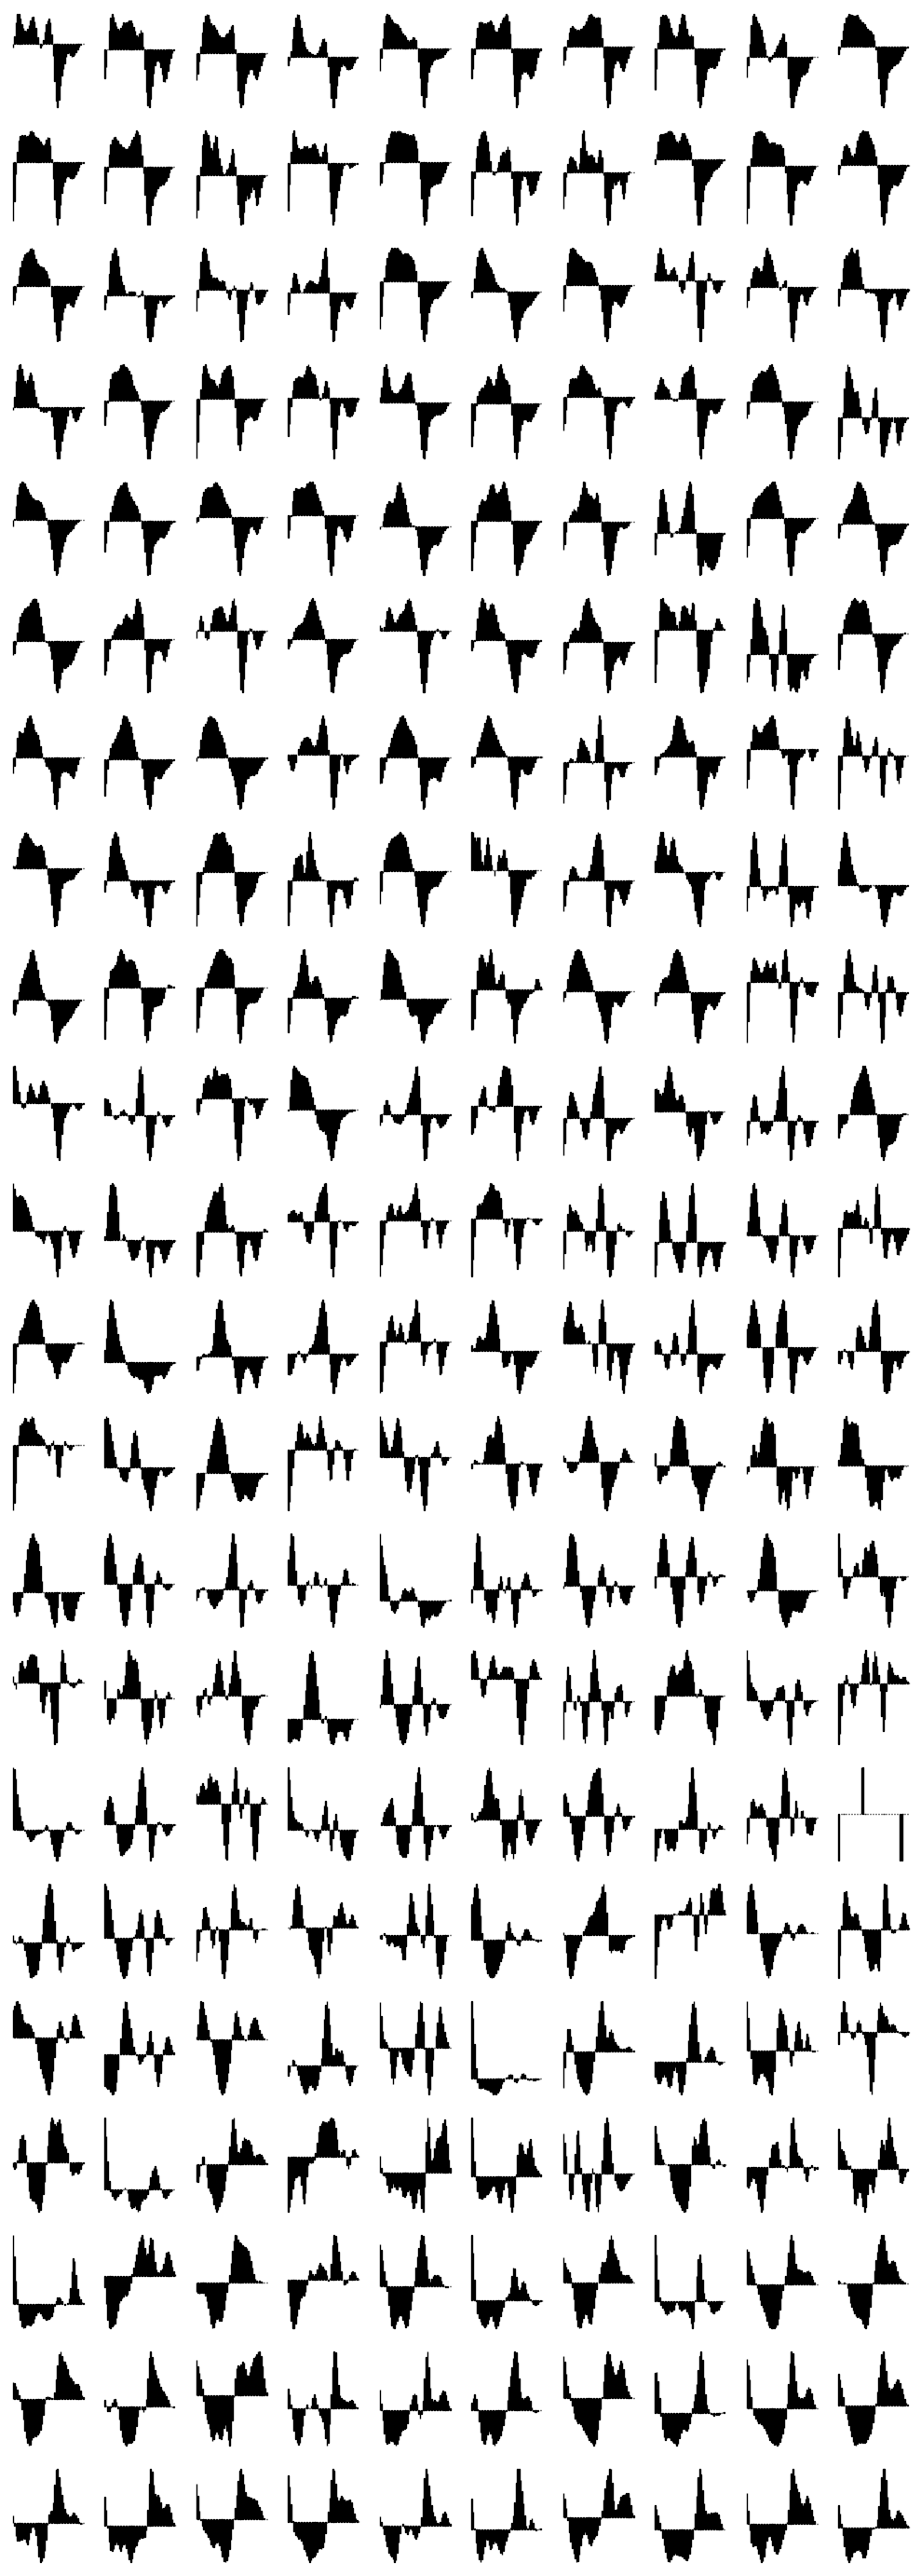

In [16]:
# Plot

# Get sorting order from the first list
sorted_indices = sort_by_cosine_similarity(norm_autocorr_1ds)
sorted_norm_autocorr_1ds = apply_sorting_order(norm_autocorr_1ds, sorted_indices)

bin_centres = 0.5*(bin_edges[1:]+bin_edges[:-1])

ncols = 10
nrows = int(np.ceil(len(sorted_norm_autocorr_1ds)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(sorted_norm_autocorr_1ds)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(sorted_norm_autocorr_1ds):
            ax[j, i].bar(bin_centres, sorted_norm_autocorr_1ds[counter],
                          color="black", edgecolor="black", align="edge")
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()

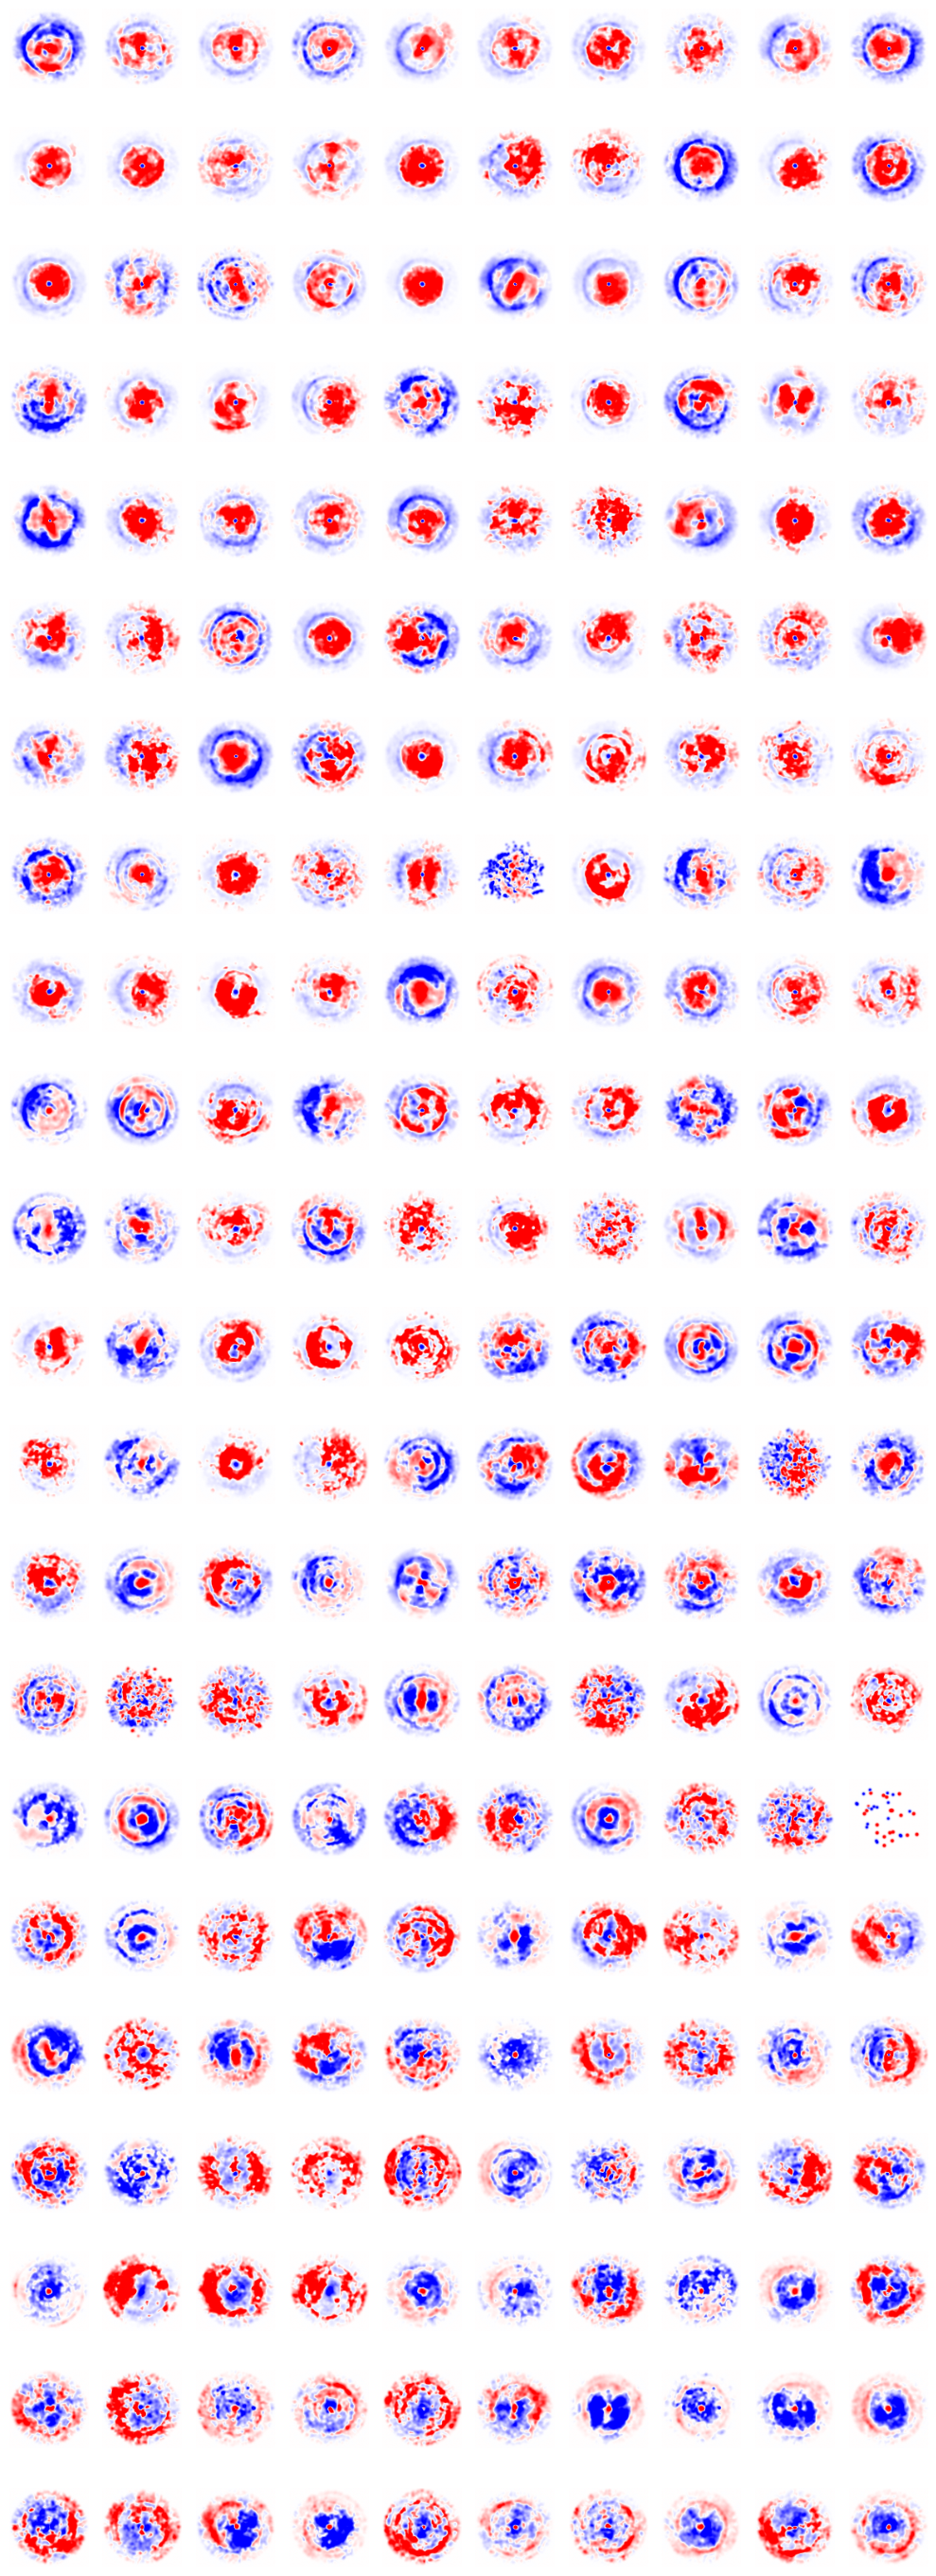

In [17]:
# Plot

# Get sorting order from the first list
sorted_indices = sort_by_cosine_similarity(norm_autocorr_1ds)
sorted_norm_autocorr_2ds = apply_sorting_order(norm_autocorr_2ds, sorted_indices)


ncols = 10
nrows = int(np.ceil(len(sorted_norm_autocorr_2ds)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
                       figsize=(10, 3*(np.ceil(len(sorted_norm_autocorr_2ds)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(sorted_norm_autocorr_2ds):
            hm = sorted_norm_autocorr_2ds[counter]

            norm = TwoSlopeNorm(vmin=np.nanmin(hm)*0.5, 
                                vcenter=0, 
                                vmax=np.nanmax(hm)*0.3)
            ax[j, i].imshow(hm, cmap='bwr', norm=norm)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_visible(False)
        ax[j, i].yaxis.set_visible(False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()